In [89]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.model_selection import train_test_split
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [15]:
weather = pd.read_csv('weather.csv')
rides = pd.read_csv('cab_rides.csv')

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [16]:
rides['time'] = pd.to_datetime(rides['time_stamp'], unit = 'ms')
rides['date_hour'] = rides['time'].dt.strftime('%Y-%m-%d:%H.%M.%S')
weather['time'] = pd.to_datetime(weather['time_stamp'], unit = 's')
weather['date_hour'] = weather['time'].dt.strftime('%Y-%m-%d:%H.%M.%S')
    
rides = rides.drop('time_stamp', axis = 1)
weather = weather.drop('time_stamp', axis = 1)

merged_data = pd.merge(left = rides, right = weather, left_on = ['source', 'date_hour'], right_on = ['location', 'date_hour'], suffixes = ('_r', '_w'))
merged_data = merged_data.drop(['location', 'time_r', 'time_w'], axis = 1)

### Data quality check
*By Elton John*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [51]:
#...Distribution of continuous variables...#

In [52]:
#...Distribution of categorical variables...#

In [53]:
#...Association of the response with the predictors...#

### Data cleaning
*By Xena Valenzuela*

From the data quality check we realized that:

1. Some of the columns that should have contained only numeric values, specifically <>, <>, and <> have special characters such as \*, #, %. We'll remove these characters, and convert the datatype of these columns to numeric.

2. Some of the columns have more than 60% missing values, and it is very difficult to impute their values, as the values seem to be missing at random with negligible association with other predictors. We'll remove such columns from the data.

3. The column `number_of_bedrooms` has some unreasonably high values such as 15. As our data consist of single-family homes in Evanston, we suspect that any value greater than 5 may be incorrect. We'll replace all values that are greater than 5 with an estimate obtained using the $K$-nearest neighbor approach.

4. The columns `house_price` has some unreasonably high values. We'll tag all values greater than 1 billion dollars as "potentially incorrect observation", to see if they distort our prediction / inference later on.

The code below implements the above cleaning.

In [17]:
merged_data['rain'] = merged_data['rain'].fillna(0)
merged_data.dropna(inplace = True)

### Data preparation
*By Sabrina Kozarovitsky*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Based on personal experience, I believe that certain hours and days may have more demand than others which may lead to higher prices. The data currently in date_hour is in a string format. In order to better use the day and time of the ride as a predictor in our model, it is important to convert date_hour into a datetime format. Additionaly, to see if hour and day may affect demand and in turn price, we can extract hour and day into separate columns to use as separate predictors. This code preparation will be useful in EDA.

In [18]:
merged_data['timestamp'] = merged_data.date_hour.apply(lambda x: (datetime.strptime(x,'%Y-%m-%d:%H.%M.%S')))

#Find hour of each trip
merged_data['hour'] = merged_data['timestamp'].dt.strftime('%H')

#Find date of each trip
merged_data['date'] = merged_data['timestamp'].dt.strftime('%Y-%m-%d') 

#Find day name of each trip
merged_data['day'] = merged_data['timestamp'].dt.day_name()

# drop redundant fields 
merged_data = merged_data.drop('timestamp', axis=1)

In [19]:
#converting hour to int to ensure that EDA graphs are in order of time
merged_data['hour'] = merged_data['hour'].astype('int')

In [20]:
product_name = {'UberX': 'Basic', 'Black': 'Sedan', 'Black SUV': 'SUV', 'UberXL': 'XL', 'UberPool': 'Shared',
                'WAV': 'Accessible', 'Lyft': 'Basic', 'Shared': 'Shared', 'Lux Black': 'Sedan', 
                'Lux Black XL': 'SUV', 'Lyft XL': 'XL', 'Lux': 'Lux'}
merged_data['product'] = merged_data['name'].map(product_name)
name_dummy_variables = pd.get_dummies(merged_data['product'], prefix = 'product')
merged_data = pd.concat([merged_data, name_dummy_variables], axis = 1)

In [27]:
merged_data.columns

Index(['distance', 'cab_type', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'date_hour', 'temp',
       'clouds', 'pressure', 'rain', 'humidity', 'wind', 'hour', 'date', 'day',
       'product', 'product_Accessible', 'product_Basic', 'product_Lux',
       'product_SUV', 'product_Sedan', 'product_Shared', 'product_XL'],
      dtype='object')

In [33]:
merged_data

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date_hour,...,date,day,product,product_Accessible,product_Basic,product_Lux,product_SUV,product_Sedan,product_Shared,product_XL
0,0.55,Uber,South Station,Theatre District,7.0,1.0,74b72f4c-28bc-4640-a427-ec60b4b11f82,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-28:17.32.07,...,2018-11-28,Wednesday,Basic,0,1,0,0,0,0,0
1,1.57,Uber,North End,Theatre District,18.0,1.0,e5aa2477-afb5-4b83-a69d-18ee7d2bfd1d,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-11-28:17.32.07,...,2018-11-28,Wednesday,Sedan,0,0,0,0,1,0,0
2,2.12,Lyft,Northeastern University,Theatre District,10.5,1.0,4d24470f-167a-4d1f-9cab-c123a0713491,lyft,Lyft,2018-11-28:17.32.07,...,2018-11-28,Wednesday,Basic,0,1,0,0,0,0,0
3,2.12,Lyft,Northeastern University,Theatre District,7.0,1.0,7902bfaf-5987-499b-9c04-222f4182c581,lyft_line,Shared,2018-11-28:17.32.07,...,2018-11-28,Wednesday,Shared,0,0,0,0,0,1,0
4,2.12,Lyft,Northeastern University,Theatre District,16.5,1.0,91129083-ed19-41fd-b16a-06c729ff0790,lyft_plus,Lyft XL,2018-11-28:17.32.07,...,2018-11-28,Wednesday,XL,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3861,0.64,Lyft,West End,Haymarket Square,27.5,1.0,06fb0785-132d-4d59-a147-00655bc1b8f9,lyft_luxsuv,Lux Black XL,2018-11-26:06.29.03,...,2018-11-26,Monday,SUV,0,0,0,1,0,0,0
3862,0.64,Lyft,West End,Haymarket Square,16.5,1.0,2be8dbc1-2a40-43e4-9e69-691420768750,lyft_lux,Lux Black,2018-11-26:06.29.03,...,2018-11-26,Monday,Sedan,0,0,0,0,1,0,0
3863,0.49,Uber,North Station,Haymarket Square,7.0,1.0,9a79355e-26e1-4f81-936e-9fa3aa06f509,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,2018-11-28:10.06.24,...,2018-11-28,Wednesday,Shared,0,0,0,0,0,1,0
3864,0.49,Uber,North Station,Haymarket Square,7.0,1.0,f92fafbf-d78b-410b-a957-f15af2022518,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-28:10.06.24,...,2018-11-28,Wednesday,Basic,0,1,0,0,0,0,0


In [28]:
#Code only done once to get train and test data
train, test = train_test_split(merged_data, test_size = 0.3)

In [30]:
#Code only done once to get .csv files of train and test data
import os  
train.to_csv('train_data_report.csv') 
test.to_csv('test_data_report.csv') 

In [31]:
train = pd.read_csv('train_data_report.csv')
test = pd.read_csv('test_data_report.csv')

In [36]:
train = train.drop('Unnamed: 0', axis = 1)
test = test.drop('Unnamed: 0', axis = 1)

In [37]:
cab_dummy_variables = pd.get_dummies(train['cab_type'], prefix = 'cab_type')
train = pd.concat([train, cab_dummy_variables], axis = 1)

cab_dummy_variables = pd.get_dummies(test['cab_type'], prefix = 'cab_type')
test = pd.concat([test, cab_dummy_variables], axis = 1)

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Cindy: General EDA

Text(23.022005111111113, 0.5, 'Price')

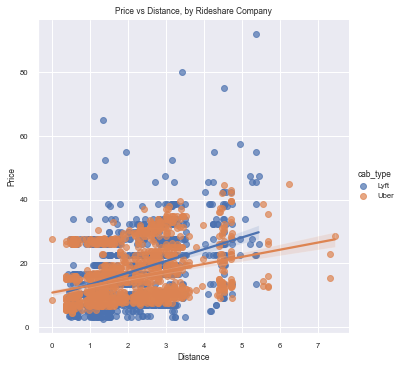

In [58]:
# seeing whether lyft vs uber is a good predictor of price
sns.lmplot(data = train, x = 'distance', y = 'price', hue = 'cab_type', scatter_kws={'alpha':0.7})
plt.title('Price vs Distance, by Rideshare Company')
plt.xlabel('Distance')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

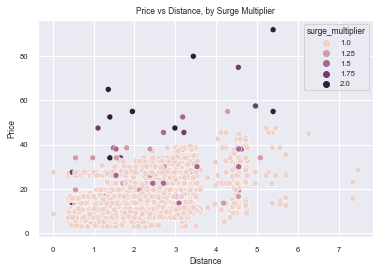

In [59]:
# investigating surge multiplier, although it was left out of further analysis since we don't know the surge multiplier value when predicting prices in real life
a = sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'surge_multiplier')
plt.title('Price vs Distance, by Surge Multiplier')
plt.xlabel('Distance')
plt.ylabel('Price')

### Cindy: Weather EDA

<AxesSubplot:xlabel='wind_d_strength', ylabel='price'>

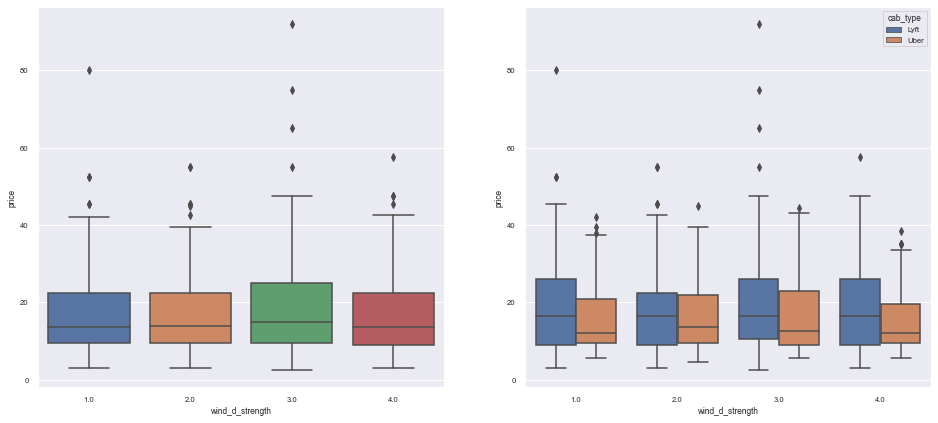

In [60]:
# wind 

# getting 25, 50, and 75th quartile amounts for wind
wd25, wd50, wd75 = train['wind'].quantile([0.25, 0.5, 0.75])
# creating separate column with values indicating how severe the wind was based on its relationship to the quartiles
train.loc[train['wind'] < wd25, 'wind_d_strength'] = 1
train.loc[((train['wind'] < wd50) & (train['wind'] >= wd25)), 'wind_d_strength'] = 2
train.loc[((train['wind'] < wd75) & (train['wind'] >= wd50)), 'wind_d_strength'] = 3
train.loc[train['wind'] >= wd75, 'wind_d_strength'] = 4
# graphing how wind strength relates to price of ride, broken down by uber/lyft 
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax=ax[0], data = train, x = 'wind_d_strength', y = 'price')
sns.boxplot(ax=ax[1], data = train, x = 'wind_d_strength', y = 'price', hue = 'cab_type')

<AxesSubplot:xlabel='pressure_d_strength', ylabel='price'>

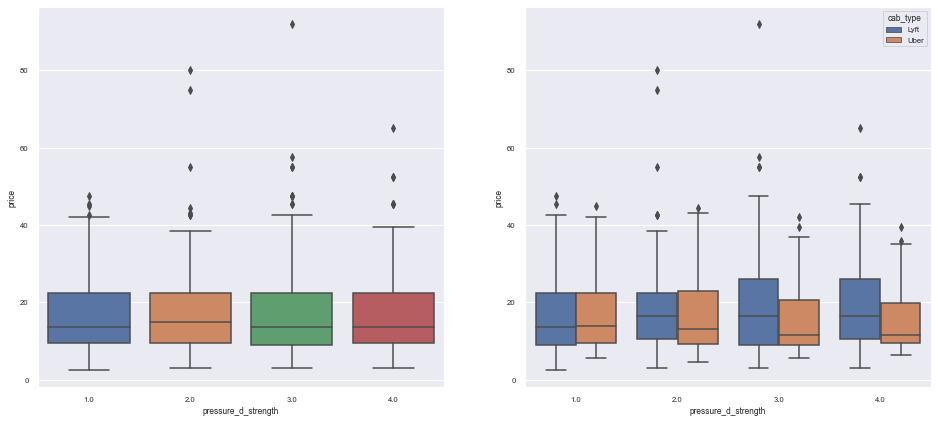

In [61]:
# pressure 

# getting 25, 50, and 75th quartile amounts for pressure
pd25, pd50, pd75 = train['pressure'].quantile([0.25, 0.5, 0.75])
# creating separate column with values indicating how severe the pressure was based on its relationship to the quartiles
train.loc[train['pressure'] < pd25, 'pressure_d_strength'] = 1
train.loc[((train['pressure'] < pd50) & (train['pressure'] >= pd25)), 'pressure_d_strength'] = 2
train.loc[((train['pressure'] < pd75) & (train['pressure'] >= pd50)), 'pressure_d_strength'] = 3
train.loc[train['pressure'] >= pd75, 'pressure_d_strength'] = 4
# graphing how pressure strength relates to price of ride, broken down by uber/lyft 
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'pressure_d_strength', y = 'price')
sns.boxplot(ax = ax[1], data = train, x = 'pressure_d_strength', y = 'price', hue = 'cab_type')


<AxesSubplot:xlabel='humidity_d_strength', ylabel='price'>

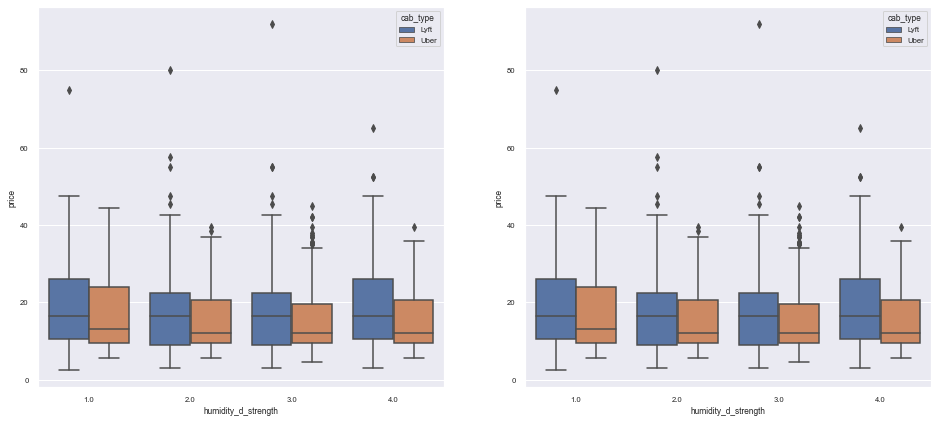

In [62]:
# humidity 

# getting 25, 50, and 75th quartile amounts for pressure
hd25, hd50, hd75 = train['humidity'].quantile([0.25, 0.5, 0.75])
#  # creating separate column with values indicating how severe the humidity was based on its relationship to the quartiles
train.loc[train['humidity'] < hd25, 'humidity_d_strength'] = 1
train.loc[((train['humidity'] < hd50) & (train['humidity'] >= hd25)), 'humidity_d_strength'] = 2
train.loc[((train['humidity'] < hd75) & (train['humidity'] >= hd50)), 'humidity_d_strength'] = 3
train.loc[train['humidity'] >= hd75, 'humidity_d_strength'] = 4
# graphing how humidity strength relates to price of ride, broken down by uber/lyft 
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'humidity_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax = ax[1], data = train, x = 'humidity_d_strength', y = 'price', hue = 'cab_type')


<AxesSubplot:xlabel='humidity_strength_3', ylabel='price'>

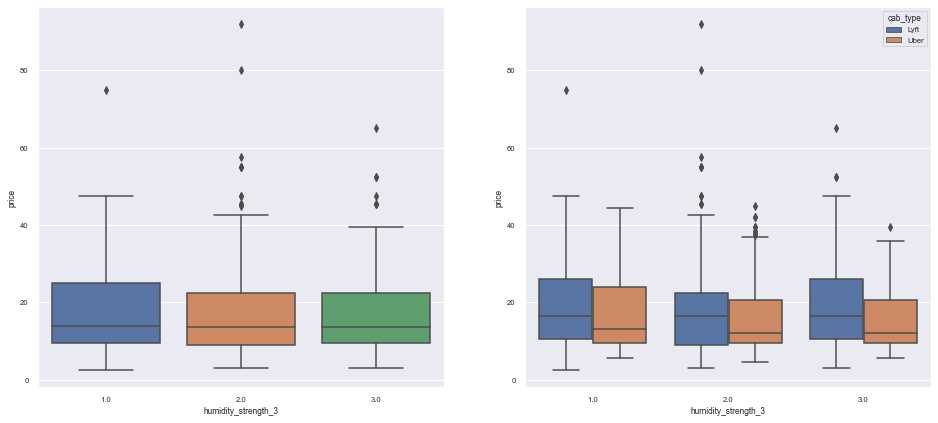

In [63]:
# trying to bin humidity into 3 instead of 4 to see if there's a stronger relationship...
train.loc[train['humidity'] < hd25, 'humidity_strength_3'] = 1
train.loc[((train['humidity'] < hd75) & (train['humidity'] >= hd25)), 'humidity_strength_3'] = 2
train.loc[train['humidity'] >= hd75, 'humidity_strength_3'] = 3
#plotting it again
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'humidity_strength_3', y = 'price')
sns.boxplot(ax = ax[1], data = train, x = 'humidity_strength_3', y = 'price', hue = 'cab_type')
# there was no real difference 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Text(0, 0.5, 'Price')]

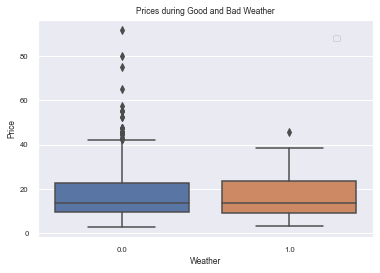

In [64]:
# instead of using humidity, pressure, and wind on its own, create another indicator value for "bad" and "good" weather
# defined bad weather as rides where wind and rain strength were in the top 25th percentile (pressure was left out bc it's likely strongly related with rain)
train.loc[(train['wind_d_strength'] == 4) & (train['pressure_d_strength'] == 4), 'bad_weather'] = 1
train.fillna(0, inplace = True)

#graph price based on whether it was good or bad weather
a = sns.boxplot(data = train, x = 'bad_weather', y = 'price')
plt.legend(bbox_to_anchor=(0.9, 0.93), borderaxespad=0)
a.set(title = 'Prices during Good and Bad Weather')
a.set(xlabel = 'Weather')
a.set(ylabel = 'Price')

Text(0, 0.5, 'Price')

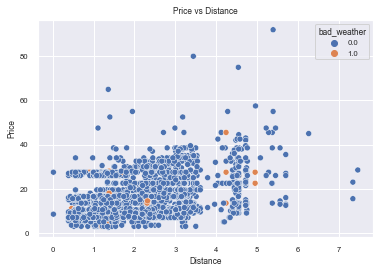

In [65]:
# investigate how bad/good weather related with distance
sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'bad_weather')
plt.title('Price vs Distance')
plt.xlabel('Distance')
plt.ylabel('Price')

### Cindy: Location EDA

In [66]:
# getting a dataframe containing the # of rides to/from each location
locationdf = pd.DataFrame(train['location'].value_counts()).reset_index()
locationdf.columns = ['location', 'count']
locationdf

,location,count
0,Haymarket Square,262
1,North Station,225
2,Northeastern University,221
3,South Station,208
4,Boston University,205
5,Theatre District,204
6,Beacon Hill,204
7,Financial District,202
8,Fenway,196
9,North End,188


[Text(0.5, 0, 'Location')]

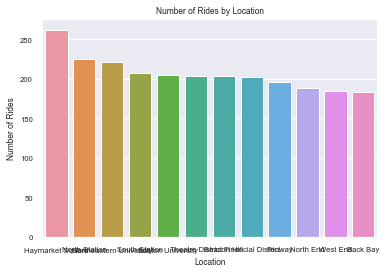

In [67]:
# it's roughly around the same area, but going to graph it to vizualize it better
a = sns.barplot(data = locationdf, x = 'location', y = 'count')
a.set(title='Number of Rides by Location')
a.set(ylabel='Number of Rides')
a.set(xlabel='Location')

In [68]:
locationprice = pd.DataFrame(train.groupby('location').agg('mean')['price']).reset_index()
locationprice

,location,price
0,Back Bay,17.467213
1,Beacon Hill,15.284314
2,Boston University,18.987805
3,Fenway,18.346939
4,Financial District,18.168317
5,Haymarket Square,14.024809
6,North End,15.781915
7,North Station,16.695556
8,Northeastern University,17.834842
9,South Station,16.192308


[Text(0.5, 0, 'Location')]

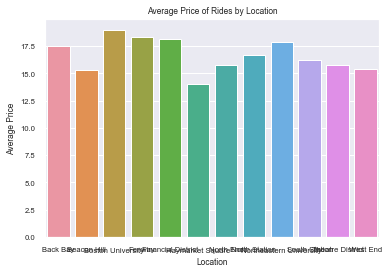

In [69]:
# vizualize avg price by location 
a = sns.barplot(data = locationprice, x = 'location', y = 'price')
a.set(title='Average Price of Rides by Location')
a.set(ylabel='Average Price')
a.set(xlabel='Location')

### Sabrina: Time EDA

<AxesSubplot:xlabel='hour', ylabel='price'>

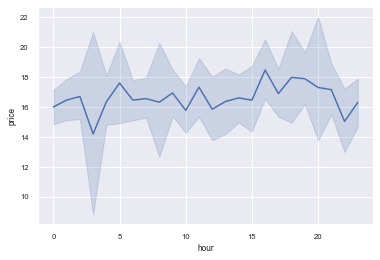

In [70]:
#Graphing to see average price by hour
sns.lineplot(x='hour', y='price', data=train)
#Average stays roughly between 14 and 18 dollars but is variable so we should consider different ways of binning hour

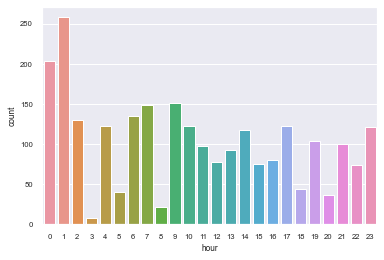

In [71]:
#Plotting counts of hour to see if some hours are more popular than others
a=sns.countplot(x='hour', data=train)
#Seems like the most rides occur between midnight and 2 am

In [72]:
#Creating function that will categorize hours with more than 150 rides as busiest, hours with approx. 100-150 rides as busy, and hours with less than 100 rides as not busy
def busy(x):
    if x['hour'] == 0 or x['hour']==1 or x['hour']==7 or x['hour']==9:
        return ('Busiest')
    if x['hour'] == 2 or x['hour']==4 or x['hour']==6 or x['hour']==10 or x['hour']==14 or x['hour']==17 or x['hour']==19 or x['hour']==22:
        return ('Busy')
    else:
        return ('Not Busy')

In [73]:
#applying function to dataframe
train['busyness'] = train.apply(lambda x: busy(x), axis=1)

Text(0.5, 1.0, 'Price Distribution by Busyness')

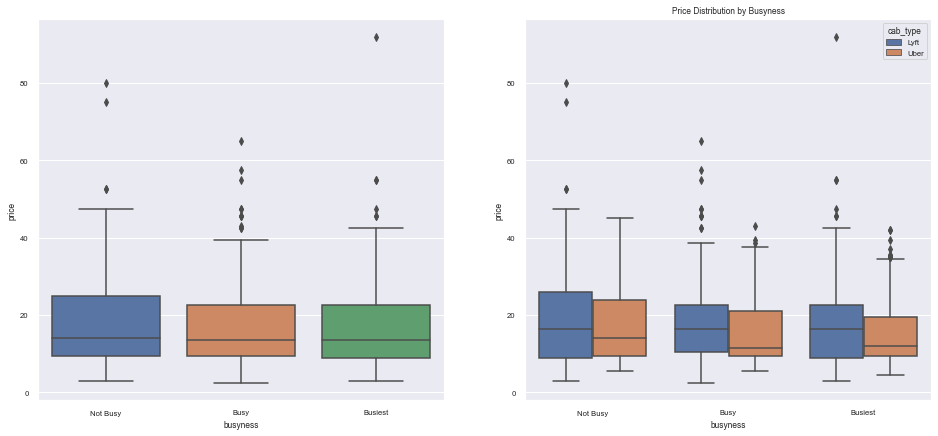

In [74]:
#Visualizing whether busier hours have higher prices
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'busyness', y = 'price')
sns.boxplot(ax = ax[1], data = train, x = 'busyness', y = 'price', hue = 'cab_type')
plt.title('Price Distribution by Busyness')
#Seems not to be much of a difference in price based on busyness overall but may make a difference for uber rides
#Surprising that less busy hours were more expensive, maybe due to lower amount of observations

Text(0, 0.5, 'Price')

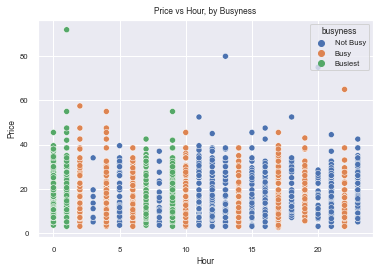

In [75]:
#Another visualization to conifirm previous conclusion
a = sns.scatterplot(data = train, x = 'hour', y = 'price', hue = 'busyness')
plt.title('Price vs Hour, by Busyness')
plt.xlabel('Hour')
plt.ylabel('Price')
#Again we can see that there is no significant difference in price by busyness of the hour

### Sabrina: Combining Hour and Location EDAs

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'South Station'),
  Text(1, 0, 'North Station'),
  Text(2, 0, 'Haymarket Square'),
  Text(3, 0, 'Theatre District'),
  Text(4, 0, 'North End'),
  Text(5, 0, 'Boston University'),
  Text(6, 0, 'Northeastern University'),
  Text(7, 0, 'Financial District'),
  Text(8, 0, 'West End'),
  Text(9, 0, 'Beacon Hill'),
  Text(10, 0, 'Fenway'),
  Text(11, 0, 'Back Bay')])

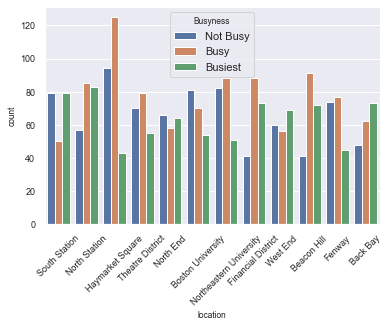

In [76]:
#Graphing Price by Locationa and Busyness
sns.countplot(x='location', data=train, hue='busyness')
plt.legend(title='Busyness', fontsize=11)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.xticks(rotation=45)

### Sabrina: Day EDA

Text(0.5, 1.0, 'Price Distribution by Day')

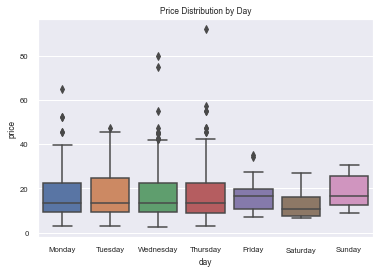

In [77]:
#Visualizing to see if price depends on day
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
sns.boxplot(x='day',y='price', data=train, order=order )
plt.title('Price Distribution by Day')
#Price seems to vary by day, Friday and Sunday seem most expensive

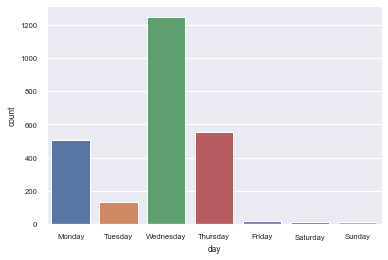

In [78]:
#Visualizing ride number per day to see if some days are busier than others
sns.set(font_scale=0.7)
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
a=sns.countplot(x='day', data=train, order=order)
#Barely any rides during the weekend which is concerning

In [79]:
train.loc[train['day']=='Sunday']
#only 11 rides
#Although price varies significantly. May be helpful in overall prediction but not so much if stakeholders are looking for weekend predictions

,Unnamed: 0,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,...,time_weather,hour,date,day,wind_d_strength,pressure_d_strength,humidity_d_strength,humidity_strength_3,bad_weather,busyness
425,3818,3.04,Uber,West End,Boston University,16.0,1.0,8b4b47cd-8398-4564-add7-9c55ef1ae144,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,...,2018-12-02 23:52:56.000,23,2018-12-02,Sunday,1.0,3.0,4.0,3.0,0.0,Not Busy
481,3798,2.30,Uber,Back Bay,Haymarket Square,30.5,1.0,2d61cf2b-2dbc-4c95-ae84-89a0e1ef6cb4,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,...,2018-12-02 19:53:05.000,19,2018-12-02,Sunday,1.0,3.0,4.0,3.0,0.0,Busy
603,3815,3.04,Uber,West End,Boston University,9.0,1.0,4ef6a5c7-e254-41ef-a6d7-78c4e5613a97,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,...,2018-12-02 23:52:56.000,23,2018-12-02,Sunday,1.0,3.0,4.0,3.0,0.0,Not Busy
733,3816,3.04,Uber,West End,Boston University,25.0,1.0,6d6fe9fa-743e-4958-bcee-dd8a7d4d7a63,6c84fd89-3f11-4782-9b50-97c468b19529,Black,...,2018-12-02 23:52:56.000,23,2018-12-02,Sunday,1.0,3.0,4.0,3.0,0.0,Not Busy
864,1069,2.72,Uber,West End,Fenway,9.0,1.0,af71ac42-de43-4aa7-b742-1fdcd7f25550,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,...,2018-12-02 19:53:04.000,19,2018-12-02,Sunday,1.0,3.0,4.0,3.0,0.0,Busy
944,1070,1.44,Lyft,Back Bay,Fenway,27.5,1.0,fa888248-99fd-44cd-be52-b6f9114254ff,lyft_luxsuv,Lux Black XL,...,2018-12-02 19:53:04.000,19,2018-12-02,Sunday,1.0,3.0,4.0,3.0,0.0,Busy
951,2630,2.84,Lyft,West End,Fenway,16.5,1.0,4c4166b6-212b-40b8-b625-b9daf9fb7134,lyft_plus,Lyft XL,...,2018-12-16 19:45:07.000,19,2018-12-16,Sunday,3.0,4.0,3.0,2.0,0.0,Busy
1053,2629,2.84,Lyft,West End,Fenway,19.5,1.0,1eb9ce60-4fb2-4a22-8814-4ab1cb3738c1,lyft_premier,Lux,...,2018-12-16 19:45:07.000,19,2018-12-16,Sunday,3.0,4.0,3.0,2.0,0.0,Busy
1333,1071,1.44,Lyft,Back Bay,Fenway,16.5,1.0,ff3ee53f-5f14-4474-a057-869fa20f7ef8,lyft_lux,Lux Black,...,2018-12-02 19:53:04.000,19,2018-12-02,Sunday,1.0,3.0,4.0,3.0,0.0,Busy
1602,2631,2.84,Lyft,West End,Fenway,26.0,1.0,685c2277-5b5d-481a-9ede-feec6c8bcbe7,lyft_lux,Lux Black,...,2018-12-16 19:45:07.000,19,2018-12-16,Sunday,3.0,4.0,3.0,2.0,0.0,Busy


<AxesSubplot:xlabel='distance_binned', ylabel='price'>

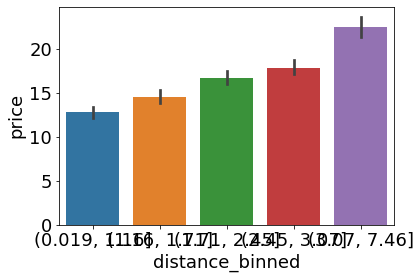

In [126]:
testing_train = train.loc[:, ['price', 'distance']]
testing_train['distance_binned'] = pd.qcut(testing_train['distance'], 5)
sns.barplot(data = testing_train, x = 'distance_binned', y = 'price')

In [69]:
train['log_distance'] = train['distance'].apply(lambda x: np.log(x))
test['log_distance'] = test['distance'].apply(lambda x: np.log(x))

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Michael: Base Models Development

In [52]:
#Test data mean for price variable
test.price.mean()

16.324882629107982

In [53]:
#Test data standard deviation for price variable
test.price.std()

9.219982314619042

In [54]:
#Creating linear regression model with distance as only predictor as base model
slr_model_initial = smf.ols(formula = 'price~distance', data = train).fit()
slr_model_initial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     362.7
Date:                Wed, 15 Mar 2023   Prob (F-statistic):           1.40e-75
Time:                        12:24:29   Log-Likelihood:                -8999.9
No. Observations:                2483   AIC:                         1.800e+04
Df Residuals:                    2481   BIC:                         1.802e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1790      0.394     25.860      0.000       9.407      10.951
distance       3.0483      0.160     19.044      0.000       2.734       3.362
==============================================================================
Omnibus:                      551.342   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1613.042
Skew:                           1.139   Prob(JB):                         0.00
Kurtosis:                       6.225   Cond. No.                         6.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
#Calculating RMSE for test data for initial linear regression model with one predictor
np.sqrt(((test.price - slr_model_initial.predict(test))**2).mean())

8.678301938753224

In [56]:
#Calculating RSE for train data for initial linear regression model with one predictor
np.sqrt(slr_model_initial.mse_resid)

9.080036716312724

In [49]:
#Creating multiple linear regression model with all ride dataset predictors as base model
mlr_model_initial = smf.ols(formula = 'price~distance+cab_type+destination+source+product_id+name+hour+day', data = train).fit()
mlr_model_initial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     432.4
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:24:23   Log-Likelihood:                -6574.9
No. Observations:                2483   AIC:                         1.323e+04
Df Residuals:                    2442   BIC:                         1.347e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              6.9984      0.892      7.842      0.000       5.248       8.748
cab_type[T.Uber]                                       0.1551      0.210      0.740      0.460      -0.256       0.566
destination[T.Beacon Hill]                            -0.1170      0.338     -0.346      0.729      -0.780       0.546
destination[T.Boston University]                       1.0152      0.307      3.305      0.001       0.413       1.618
destination[T.Fenway]                                  0.3598      0.286      1.260      0.208      -0.200       0.920
destination[T.Financial District]                      0.0841      0.340      0.247      0.805      -0.583       0.751
destination[T.Haymarket Square]                        1.1674      0.306      3.809      0.000       0.566       1.768
destination[T.North End]                               0.8629      0.294      2.940      0.003       0.287       1.439
destination[T.North Station]                           0.6755      0.337      2.006      0.045       0.015       1.336
destination[T.Northeastern University]                 0.6413      0.313      2.046      0.041       0.027       1.256
destination[T.South Station]                           1.1338      0.295      3.849      0.000       0.556       1.711
destination[T.Theatre District]                        0.0676      0.336      0.201      0.841      -0.592       0.727
destination[T.West End]                               -0.1714      0.344     -0.498      0.618      -0.846       0.503
source[T.Beacon Hill]                                 -1.1158      0.355     -3.144      0.002      -1.812      -0.420
source[T.Boston University]                           -0.0673      0.308     -0.218      0.827      -0.671       0.536
source[T.Fenway]                                       0.4460      0.302      1.476      0.140      -0.147       1.039
source[T.Financial District]                          -0.1162      0.356     -0.327      0.744      -0.814       0.582
source[T.Haymarket Square]                             0.1766      0.280      0.632      0.528      -0.372       0.725
source[T.North End]                                    0.9282      0.295      3.144      0.002       0.349       1.507
source[T.North Station]                               -1.0378      0.347     -2.990      0.003      -1.718      -0.357
source[T.Northeastern University]                      0.1336      0.301      0.444      0.657      -0.457       0.724
source[T.South Station]                                0.2007      0.299      0.671      0.502      -0.386       0.787
source[T.Theatre District]                            -0.3212      0.353     -0.911      0.362      -1.013  

In [58]:
#Calculating RMSE for test data for initial multiple linear regression model with six predictor
np.sqrt(((test.price - mlr_model_initial.predict(test))**2).mean())

3.064524588225444

In [59]:
#Calculating RSE for train data for initial multiple linear regression model with six predictors
np.sqrt(mlr_model_initial.mse_resid)

3.446525324585067

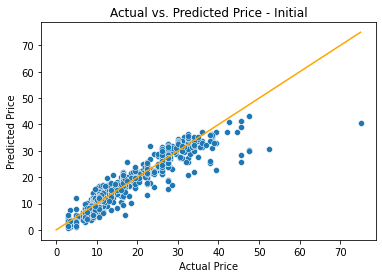

In [60]:
#Plotting predicted price against actual price
mlr_graph = sns.scatterplot(x = test.price, y = mlr_model_initial.predict(test))
mlr_graph = sns.lineplot(x = [0, test.price.max()], y = [0, test.price.max()], color = 'orange')
mlr_graph = mlr_graph.set(xlabel = 'Actual Price', ylabel = 'Predicted Price', title = 'Actual vs. Predicted Price - Initial')

The above graph of actual vs. predicted price plot shows that the plotted points don't end up seeming to follow the exact line trend of predicted price = actual price as the actual price increases.

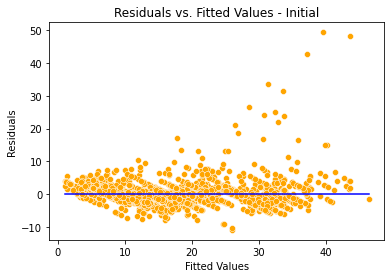

In [61]:
#Plotting residuals against fitted values to address model assumptions
mlr_residuals = sns.scatterplot(x = mlr_model_initial.fittedvalues, y=mlr_model_initial.resid,color = 'orange')
mlr_residuals = sns.lineplot(x = [mlr_model_initial.fittedvalues.min(),mlr_model_initial.fittedvalues.max()],y = [0,0],color = 'blue')
mlr_residuals = mlr_residuals.set(xlabel='Fitted Values', ylabel='Residuals', title='Residuals vs. Fitted Values - Initial')

While this base model did mostly seem to not violate the linearity assumption, there did seem to be a problematic trend as the fitted values increased that residuals tended to stray away from the line of residuals = 0 that could mean it violated the constant variance assumption, so log transformation on price may be done in future models. 

In [132]:
mlr_model_weather = smf.ols(formula = 'np.log(price)~distance+cab_type_Uber+cab_type_Lyft+source+destination+temp+clouds+pressure+rain+humidity+wind+hour+day+product_Accessible+product_Lux+product_Shared+product_Basic+product_SUV+product_Sedan+product_XL', data = train).fit()
mlr_model_weather.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     561.1
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:40:23   Log-Likelihood:                 804.99
No. Observations:                2483   AIC:                            -1524.
Df Residuals:                    2440   BIC:                            -1274.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  2.7093      1.452      1.867      0.062      -0.137       5.556
source[T.Beacon Hill]                     -0.0453      0.018     -2.488      0.013      -0.081      -0.010
source[T.Boston University]                0.1671      0.122      1.371      0.170      -0.072       0.406
source[T.Fenway]                           0.2071      0.122      1.699      0.089      -0.032       0.446
source[T.Financial District]              -0.0733      0.018     -4.019      0.000      -0.109      -0.038
source[T.Haymarket Square]                 0.2039      0.122      1.668      0.095      -0.036       0.444
source[T.North End]                        0.2455      0.122      2.015      0.044       0.007       0.484
source[T.North Station]                   -0.0504      0.018     -2.829      0.005      -0.085      -0.015
source[T.Northeastern University]          0.2228      0.123      1.817      0.069      -0.018       0.463
source[T.South Station]                    0.1998      0.121      1.654      0.098      -0.037       0.437
source[T.Theatre District]                 0.0013      0.018      0.070      0.944      -0.034       0.037
source[T.West End]                        -0.0435      0.018     -2.355      0.019      -0.080      -0.007
destination[T.Beacon Hill]                 0.0124      0.017      0.714      0.476      -0.022       0.046
destination[T.Boston University]           0.2371      0.122      1.947      0.052      -0.002       0.476
destination[T.Fenway]                      0.2301      0.122      1.882      0.060      -0.010       0.470
destination[T.Financial District]         -0.0396      0.017     -2.269      0.023      -0.074      -0.005
destination[T.Haymarket Square]            0.2566      0.122      2.106      0.035       0.018       0.496
destination[T.North End]                   0.2463      0.122      2.027      0.043       0.008       0.485
destination[T.North Station]               0.0052      0.017      0.300      0.764      -0.029       0.039
destination[T.Northeastern University]     0.2354      0.122      1.928      0.054      -0.004       0.475
destination[T.South Station]               0.2574      0.122      2.117      0.034       0.019       0.496
destination[T.Theatre District]            0.0205      0.017      1.185      0.236      -0.013       0.054
destination[T.West End]                   -0.0029      0.018     -0.166      0.868      -0.038       0.032
day[T.Monday]                             -0.0254      0.103     -0.247      0.805      -0.227       0.176
day[T.Saturday]                           -0.0989      0.088     -1.129      0.259      -0.271       0.073
day[T.Sunday]                             -0.1153      0.137     -0.839      0.402     

In [133]:
#Calculating RMSE for test data for intermediate multiple linear regression model with weather predictors and dummy variables
np.sqrt(((test.price - np.exp(mlr_model_weather.predict(test)))**2).mean())

3.113855857649776

In [134]:
#Calculating RSE for train data for intermediate multiple linear regression model with weather predictors and dummy variables
pred_price = np.exp(mlr_model_weather.predict(train))
residuals = train.price - pred_price
np.sqrt(np.mean(residuals**2))

3.5466560523159383

In [112]:
#Getting 2-factor interactions as predictor variables for upcoming lasso regression model
X = train[['distance', 'temp', 'clouds', 'pressure', 'rain',
                    'humidity', 'wind', 'hour', 'product_Accessible', 'product_Basic', 'log_distance',
                    'product_Lux','product_SUV', 'product_Sedan', 'product_Shared', 'product_XL','cab_type_Lyft', 'cab_type_Uber']]

for combo in itertools.combinations(X.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 

In [113]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    return models_best

In [114]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('np.log(price)~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    toc = time.time()
    
    return best_model

def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
    
    print(1+bic.argmin())

18


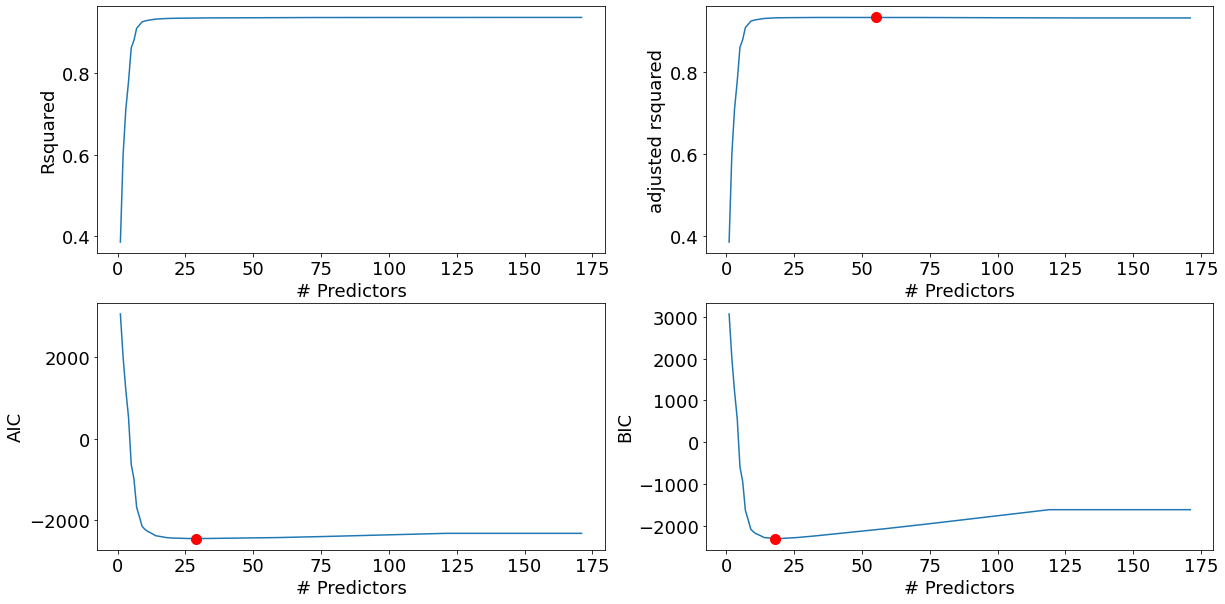

In [115]:
models_best = forward_selection()
best_sub_plots()

In [116]:
best_fwd_reg_model = models_best['model'][18]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1916.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:26:36   Log-Likelihood:                 1228.6
No. Observations:                2483   AIC:                            -2419.
Df Residuals:                    2464   BIC:                            -2309.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.7263      0.022     77.177      0.000       1.682       1.770
product_SUV                      1.1323      0.025     45.514      0.000       1.084       1.181
distance_product_Sedan           0.1176      0.023      5.096      0.000       0.072       0.163
product_Shared_cab_type_Lyft    -0.4159      0.018    -23.535      0.000      -0.451      -0.381
distance_product_XL              0.0443      0.007      6.064      0.000       0.030       0.059
distance_product_Lux             0.0633      0.011      5.741      0.000       0.042       0.085
distance                         0.2943      0.018     16.080      0.000       0.258       0.330
product_Sedan                    0.5912      0.029     20.410      0.000       0.534       0.648
product_XL                       0.3570      0.018     19.705      0.000       0.322       0.393
pressure_product_Lux             0.0005   2.78e-05     16.708      0.000       0.000       0.001
log_distance_cab_type_Lyft       0.0403      0.011      3.785      0.000       0.019       0.061
product_Shared                  -0.1087      0.012     -8.875      0.000      -0.133      -0.085
log_distance_product_SUV        -0.1884      0.030     -6.201      0.000      -0.248      -0.129
distance_log_distance           -0.0787      0.009     -8.367      0.000      -0.097      -0.060
product_Sedan_cab_type_Lyft      0.1352      0.017      7.855      0.000       0.101       0.169
product_SUV_cab_type_Lyft        0.0911      0.017      5.329      0.000       0.058       0.125
pressure_cab_type_Uber        4.249e-05   1.13e-05      3.749      0.000    2.03e-05    6.47e-05
log_distance_product_Sedan      -0.1738      0.043     -4.087      0.000      -0.257      -0.090
distance_product_SUV             0.0574      0.017      3.459      0.001       0.025       0.090
==============================================================================
Omnibus:                      424.488   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3467.372
Skew:                           0.567   Prob(JB):                         0.00
Kurtosis:                       8.677   Cond. No.                     1.32e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [117]:
#Calculating RMSE for test data for final multiple linear regression model with selected predictors
np.sqrt(((test.price - np.exp(best_fwd_reg_model.predict(test)))**2).mean())

2.6915216311089334

In [122]:
#Calculating RSE for train data for final multiple linear regression model with selected predictors
price_pred = np.exp(best_fwd_reg_model.predict(train))
residuals = train.price - price_pred
np.sqrt(np.mean(residuals**2))

3.057923473831309

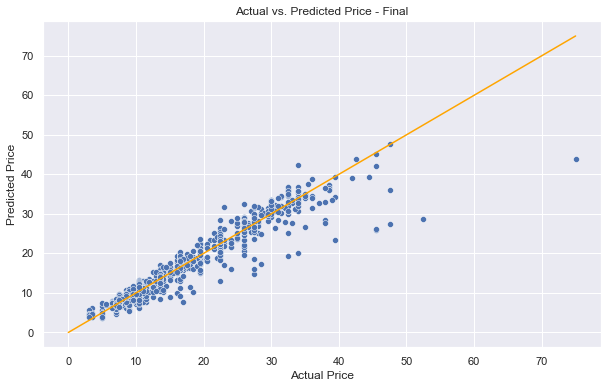

In [127]:
#Plotting predicted price against actual price
sns.set(rc={'figure.figsize':(10,6)})
final_graph = sns.scatterplot(x = test.price, y = np.exp(best_fwd_reg_model.predict(test)))
final_graph = sns.lineplot(x = [0, test.price.max()], y = [0, test.price.max()], color = 'orange')
final_graph = final_graph.set(xlabel = 'Actual Price', ylabel = 'Predicted Price', title = 'Actual vs. Predicted Price - Final')

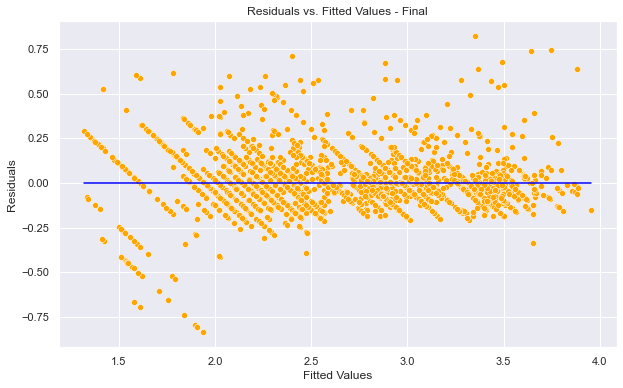

In [128]:
#Plotting residuals against fitted values to address model assumptions
final_residuals = sns.scatterplot(x = best_fwd_reg_model.fittedvalues, y = best_fwd_reg_model.resid,color = 'orange')
final_residuals = sns.lineplot(x = [best_fwd_reg_model.fittedvalues.min(),best_fwd_reg_model.fittedvalues.max()],y = [0,0],color = 'blue')
final_residuals = final_residuals.set(xlabel='Fitted Values', ylabel='Residuals', title='Residuals vs. Fitted Values - Final')

### Keaton: Outlier/High-Leverage/Influential Point Detection and Analysis

In [44]:
#get studentized residuals of baseline model
out = mlr_model_initial.outlier_test()
#output number of outliers in the data
np.sum((np.abs(out.student_resid)>3))

/Users/sabrina/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


25

In [45]:
#calculate number of outliers as percent of total observations
25/train.shape[0]

0.010068465565847765

In [46]:
#get the influence of the observations
influence = mlr_model_initial.get_influence()
leverage = influence.hat_matrix_diag
average_leverage = (mlr_model_initial.df_model+1)/mlr_model_initial.nobs

In [47]:
#calculate the high leverage threshold
high_leverage_threshold = 4*average_leverage
#output the number of high leverage points
np.sum(leverage>high_leverage_threshold)

0

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [130]:
#May be useful to run code above to get this final model using forward regression model
best_fwd_reg_model = models_best['model'][18]

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.